<a href="https://colab.research.google.com/github/Nicocro/TF2_Course/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [21]:
import tensorflow as tf
from scipy.io import loadmat

#------------------- inports #
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


In [2]:
#check version and GPU usage
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.3.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/My Drive/TF2_Capstone/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/TF2_Capstone/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:
for x in train:
  print(x)

__header__
__version__
__globals__
X
y


In [7]:
#build a np array with train images
x_train = train['X']
x_train = np.moveaxis(x_train, -1, 0)

#build numpy array with train labels
y_train = train['y']

#build a np array with test images
x_test = test['X']
x_test = np.moveaxis(x_test, -1, 0)

#build numpy array with test labels
y_test = test['y']

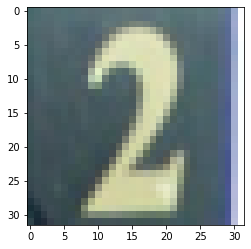

label: [2]


In [8]:
#display one of the images

i = 43 
img = x_train[i,:,:,:]
plt.imshow(img)
plt.show()
print(f"label: {y_train[i]}")

In [9]:
# convert images to greyscale
x_train_gs = np.average(x_train, axis=-1)
x_test_gs = np.average(x_test, axis=-1)

In [10]:
#shape checks
print("x_train_gs shape:",x_train_gs.shape)
print("y_train shape:", y_train.shape)
print("x_test_gs shape:",x_test_gs.shape)
print("y_test shape:", y_test.shape)

x_train_gs shape: (73257, 32, 32)
y_train shape: (73257, 1)
x_test_gs shape: (26032, 32, 32)
y_test shape: (26032, 1)


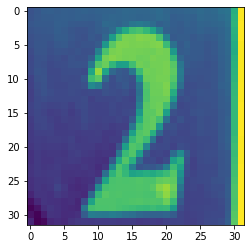

label: [2]


In [11]:
#showing greyscale image (it is greyscale even if plt distorts colors)
i = 43 
img = x_train_gs[i,:,:]
plt.imshow(img)
plt.show()
print(f"label: {y_train[i]}")

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
#design the model and print summary

model = Sequential([
    Flatten(input_shape=x_train_gs[0].shape),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(11, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                715       
Total params: 74,635
Trainable params: 74,635
Non-trainable params: 0
_________________________________________________________________


In [13]:
#compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# callbacks 1: model checkpoint based on performance

checkpoint_best_path = '/content/gdrive/My Drive/TF2_Capstone/model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=True,
                                 save_freq='epoch',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)
#callback 2: earlystopping
earlystopping = EarlyStopping(patience=2, monitor='val_accuracy')

In [15]:
#fit the model
history = model.fit(x_train_gs, y_train, 
                    callbacks=[checkpoint_best, earlystopping],
                    batch_size= 128,
                    validation_data=(x_test_gs, y_test), 
                    epochs = 20)

Epoch 1/20
553/573 [===========================>..] - ETA: 0s - loss: 4.3259 - accuracy: 0.1604
Epoch 00001: val_accuracy improved from -inf to 0.26348, saving model to /content/gdrive/My Drive/TF2_Capstone/model_checkpoints_best/checkpoint
573/573 [==============================] - 2s 4ms/step - loss: 4.2557 - accuracy: 0.1632 - val_loss: 2.2170 - val_accuracy: 0.2635
Epoch 2/20
570/573 [============================>.] - ETA: 0s - loss: 1.9280 - accuracy: 0.3582
Epoch 00002: val_accuracy improved from 0.26348 to 0.43754, saving model to /content/gdrive/My Drive/TF2_Capstone/model_checkpoints_best/checkpoint
573/573 [==============================] - 2s 3ms/step - loss: 1.9267 - accuracy: 0.3586 - val_loss: 1.7085 - val_accuracy: 0.4375
Epoch 3/20
564/573 [============================>.] - ETA: 0s - loss: 1.5313 - accuracy: 0.5083
Epoch 00003: val_accuracy improved from 0.43754 to 0.52881, saving model to /content/gdrive/My Drive/TF2_Capstone/model_checkpoints_best/checkpoint
573/573 [

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

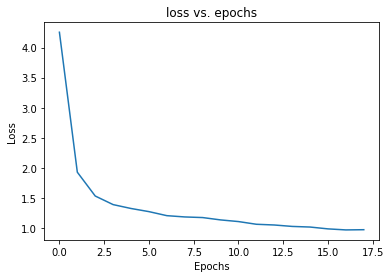

In [16]:
# Load the history into a pandas Dataframe
df = pd.DataFrame(history.history)
df.head()

# Make a plot for the loss

loss_plot = df.plot(y='loss', title = 'loss vs. epochs', legend = False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'Epochs')]

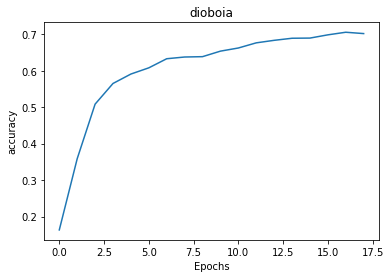

In [17]:
# Make a plot for the accuracy

accuracy_plot = df.plot(y='accuracy', title= 'dioboia', legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="accuracy")


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
#design the model and print summary
model_CNN = Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape=x_train[0].shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='valid', strides=1, activation='relu'),
    MaxPooling2D((1,1), strides =3),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding='valid', strides=2, activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(11, activation='softmax') #this layer has 11 units (0-10) to use the integer labels
])

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 64)         

In [23]:
#compile model
model_CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# callbacks 1: model checkpoint based on performance

checkpointCNN_best_path = '/content/gdrive/My Drive/TF2_Capstone/modelCNN_checkpoints_best/checkpoint'
checkpointCNN_best = ModelCheckpoint(filepath=checkpointCNN_best_path,
                                 save_weights_only=True,
                                 save_freq='epoch',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)
#callback 2: earlystopping
earlystoppingCNN = EarlyStopping(patience=2, monitor='val_accuracy', verbose=1)

In [25]:
#fit the model
historyCNN = model_CNN.fit(x_train, y_train, 
                    callbacks=[checkpointCNN_best, earlystoppingCNN],
                    batch_size= 128,
                    validation_data=(x_test, y_test), 
                    epochs = 20)

Epoch 1/20
573/573 [==============================] - ETA: 0s - loss: 1.2897 - accuracy: 0.5659
Epoch 00001: val_accuracy improved from -inf to 0.80724, saving model to /content/gdrive/My Drive/TF2_Capstone/modelCNN_checkpoints_best/checkpoint
573/573 [==============================] - 4s 7ms/step - loss: 1.2897 - accuracy: 0.5659 - val_loss: 0.6314 - val_accuracy: 0.8072
Epoch 2/20
565/573 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.8033
Epoch 00002: val_accuracy improved from 0.80724 to 0.83989, saving model to /content/gdrive/My Drive/TF2_Capstone/modelCNN_checkpoints_best/checkpoint
573/573 [==============================] - 4s 6ms/step - loss: 0.6285 - accuracy: 0.8034 - val_loss: 0.5198 - val_accuracy: 0.8399
Epoch 3/20
572/573 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.8373
Epoch 00003: val_accuracy improved from 0.83989 to 0.87796, saving model to /content/gdrive/My Drive/TF2_Capstone/modelCNN_checkpoints_best/checkpoint


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

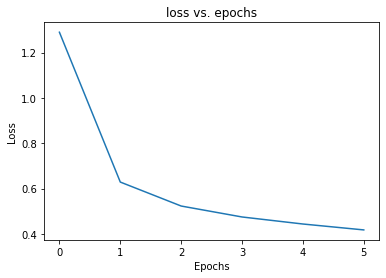

In [27]:
# Load the history into a pandas Dataframe
df_CNN = pd.DataFrame(historyCNN.history)
df_CNN.head()

# Make a plot for the loss

loss_plot_CNN = df_CNN.plot(y='loss', title = 'loss vs. epochs', legend = False)
loss_plot_CNN.set(xlabel="Epochs", ylabel="Loss")

[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'Epochs')]

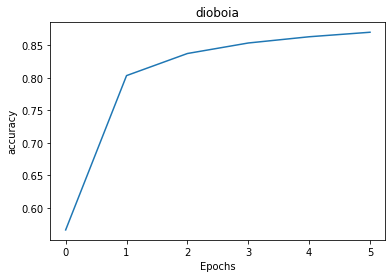

In [28]:
# Make a plot for the accuracy

accuracy_plot_CNN = df_CNN.plot(y='accuracy', title= 'dioboia', legend=False)
accuracy_plot_CNN.set(xlabel="Epochs", ylabel="accuracy")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.